In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

print(torch.__version__)
print(torch.cuda.is_available())

1.6.0
True


# 1. Dataset
- Simulate: series(t) = sin(t) + noise

In [2]:
N = 1000

t = 0.1*np.arange(N)
series = np.sin(t) + np.random.randn(N)*0.1

series.shape

(1000,)

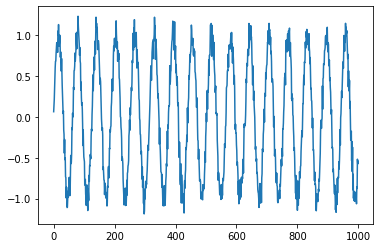

In [3]:
plt.plot(series)
plt.show()

#### Define dataset
- Predict y(next t+10) based on X

In [4]:
T = 10
X = []
y = []

for t in range(len(series) - T):
    x_series = series[t:t+T]
    X.append(x_series)

    y_series = series[t+T]
    y.append(y_series)

X = np.array(X).reshape(-1, T, 1)
y = np.array(y).reshape(-1, 1)
print("X.shape", X.shape, "y.shape", y.shape)

X.shape (990, 10, 1) y.shape (990, 1)


#### Train-test split

In [5]:
N = len(X)

X_train = X[:-N//2]
y_train = y[:-N//2]

X_test = X[:-N//2:]
y_test = y[:-N//2:]

#### Convert to torch tensor

In [6]:
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
print(X_train.shape, y_train.shape)


X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))
print(X_test.shape, y_test.shape)

torch.Size([495, 10, 1]) torch.Size([495, 1])
torch.Size([495, 10, 1]) torch.Size([495, 1])


#### move data to GPU

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using", device)

Using cuda


In [8]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# 2. Model

In [9]:
import torch.nn as nn

class SimpleRNN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(SimpleRNN, self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers

        # note: batch_first=True
        # applies the convention that our data will be of shape:
        # (num_samples, sequence_length, num_features)
        # rather than:
        # (sequence_length, num_samples, num_features)
        self.rnn = nn.RNN(
            input_size=self.D,
            hidden_size=self.M,
            num_layers=self.L,
            nonlinearity='relu',
            batch_first=True)
        self.fc = nn.Linear(self.M, self.K)
  
    def forward(self, X):
        # initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)

        # get RNN unit output
        # out is of size (N, T, M)
        # 2nd return value is hidden states at each hidden layer
        # we don't need those now
        out, _ = self.rnn(X, h0)

        # we only want h(T) at the final time step
        # N x M -> N x K
        out = self.fc(out[:, -1, :])
        return out

In [10]:
# Model
rnn_model = SimpleRNN(n_inputs=1, n_hidden=15, n_rnnlayers=1, n_outputs=1)
rnn_model.to(device)
print(rnn_model)

# Loss
mse_loss = nn.MSELoss()

# Optimizer
adam_opt = torch.optim.Adam(rnn_model.parameters(), lr=0.001)

SimpleRNN(
  (rnn): RNN(1, 15, batch_first=True)
  (fc): Linear(in_features=15, out_features=1, bias=True)
)


# 3. Train

In [11]:
def fit(X_train, y_train, X_valid, y_valid,
        model, loss_fn, optimizer, epochs=1000):

    train_losses = np.zeros(epochs)
    valid_losses = np.zeros(epochs)
    for i in range(epochs):
        # zero gradients
        optimizer.zero_grad()

        # Forward
        y_train_ = model(X_train)
        loss = loss_fn(y_train_, y_train)
      
        # Backward
        loss.backward()
        optimizer.step()

        # Fit valid
        y_valid_ = model(X_valid)
        valid_loss = loss_fn(y_valid_, y_valid)

        # Save losses
        train_losses[i] = loss.item()
        valid_losses[i] = valid_loss.item()
      
        if (i + 1) % 100 == 0:
            print(f'Epoch {i+1}/{epochs}, Train Loss: {loss.item():.4f}, Valid Loss: {valid_loss.item():.4f}')

    # Plot
    plt.plot(train_losses, label='train loss')
    plt.plot(valid_losses, label='valid loss')
    plt.legend()
    plt.show()

Epoch 100/1000, Train Loss: 0.1109, Valid Loss: 0.1091
Epoch 200/1000, Train Loss: 0.0202, Valid Loss: 0.0199
Epoch 300/1000, Train Loss: 0.0147, Valid Loss: 0.0147
Epoch 400/1000, Train Loss: 0.0140, Valid Loss: 0.0140
Epoch 500/1000, Train Loss: 0.0137, Valid Loss: 0.0137
Epoch 600/1000, Train Loss: 0.0135, Valid Loss: 0.0135
Epoch 700/1000, Train Loss: 0.0132, Valid Loss: 0.0132
Epoch 800/1000, Train Loss: 0.0130, Valid Loss: 0.0130
Epoch 900/1000, Train Loss: 0.0129, Valid Loss: 0.0129
Epoch 1000/1000, Train Loss: 0.0128, Valid Loss: 0.0128


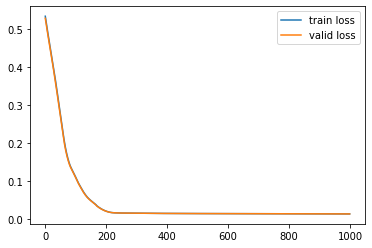

In [12]:
X_valid = X_test
y_valid = y_test

fit(X_train, y_train, X_valid, y_valid,
    model=rnn_model, loss_fn=mse_loss, optimizer=adam_opt,
    epochs=1000)

# 5. Test

In [13]:
i = 0
y_test_ = []

while len(y_test_) < len(y_test):
    Xb_test = X_test[i].view(1, T, 1)
    yb_test_ = rnn_model(Xb_test)[0,0].item() # 1x1 array -> scalar
    i += 1
  
    # update the predictions list
    y_test_.append(yb_test_)

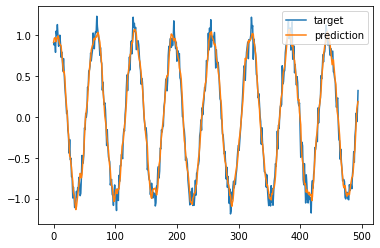

In [14]:
plt.plot(y_test.cpu(), label='target')
plt.plot(y_test_, label='prediction')
plt.legend()
plt.show()